# Introduction
Script shows how to load horizons for K2 Data and visualize them on the interpreted seismic volume sorted by inlines and crossliness

In [1]:
import numpy as np
import segyio
import matplotlib.pyplot as plt
from mayavi import mlab

In [53]:
# read seismic by inline and crossline positions
def segy2npy(segy_path):
    """function takes an unstructured segy file and creates a numpy array corresponding to the 3D seismic volume

    Args:
        segy_path (string): path to segy file

    Returns:
        numpy_vol (array): 3D numpy array of the form crosslines x inlines x samples representing the seismic volume
        xlines (array): array of sorted unique xline numbers in the segy file
        ilines (array): array of sorted unique inline numbers in the segy file
        samples (array): array of time/depth samples in segy file
    """

    # read segy file
    segy_file = segyio.open(segy_path, ignore_geometry=True)

    # get a list of all crosslines in the file
    all_xlines = np.array([segy_file.header[i][segyio.TraceField.CROSSLINE_3D] for i in range(0,segy_file.tracecount,10)])
    unique_xlines = np.unique(all_xlines).astype(int)

    # get a list of all inlines in the file
    all_ilines = np.array([segy_file.header[i][segyio.TraceField.INLINE_3D] for i in range(0,segy_file.tracecount,10)])
    unique_ilines = np.unique(all_ilines).astype(int)

    # array of depth\time samples
    samples = segy_file.samples

    # create numpy array to store seismic volume
    seismic_cube = np.zeros((unique_ilines.size, unique_xlines.size, samples.size))

    print("Parsing Segy File...")
    for i in range(segy_file.tracecount):
        # find relative inline position for trace
        absolute_xline = int(segy_file.header[i][segyio.TraceField.CROSSLINE_3D])
        relative_xline = np.where(unique_xlines==absolute_xline)[0].item()

        # find relative crossline position for trace
        absolute_iline = int(segy_file.header[i][segyio.TraceField.INLINE_3D])
        relative_iline = np.where(unique_ilines==absolute_iline)[0].item()

        seismic_cube[relative_iline, relative_xline] = segy_file.trace[i]

    print("Segy parsing completed!")

    return seismic_cube, unique_xlines, unique_ilines, samples

# clips a numpy array to within 3 standard deviations of the mean
def clip(array):
    std = array.std()
    return np.clip(array, -3*std, 3*std)

# returns horizon indices in absolute coordinates to plot on matplotlib
def plot_horizon(path_horizon_file, unique_xlines, unique_ilines, samples, xline_idx=300):
    
    horizon_file = np.genfromtxt(path_horizon_file)
    
    # extract horizon picks
    il_hrz = horizon_file[1:,0].astype(int)
    xl_hrz = horizon_file[1:,1].astype(int)
    t_hrz = horizon_file[1:,2].astype(int)

    # only consider points lying inside the range of the seismic
    mask_valid = (il_hrz >= unique_ilines.min()) & ((il_hrz <= unique_ilines.max())) & (xl_hrz >= unique_xlines.min()) & (xl_hrz <= unique_xlines.max()) & (t_hrz <= samples.max())
    il_hrz = il_hrz[mask_valid]
    xl_hrz = xl_hrz[mask_valid]
    t_hrz = t_hrz[mask_valid]

    # digitize x,y,z positions
    il_inds = np.digitize(il_hrz, bins=np.sort(unique_ilines))
    xl_inds = np.digitize(xl_hrz, bins=np.sort(unique_xlines))
    t_inds = np.digitize(t_hrz, bins=np.sort(samples))

    # extract picks relevant to given slice
    il_ind_slice = il_inds[xl_inds==xline_idx]
    t_ind_slice = t_inds[xl_inds==xline_idx]

    return il_ind_slice, t_ind_slice


# visualize a seismic slice with tick labels showing the actual inline, xline and depth/time positions
def plot_seismic_section(seismic_array, sorted_ilines, sorted_xlines, sorted_samples, ax, **kwargs):
    
    # Specify the allowed keys
    allowed_keys = ["il_slice", "xl_slice", "depth_slice"]

    # Count the number of provided slices
    provided_slices = sum(key in kwargs for key in allowed_keys)

    # Check the number of provided slices
    if provided_slices == 0:
        raise ValueError("At least one of 'il_slice', 'xl_slice', or 'depth_slice' must be provided.")
    elif provided_slices > 1:
        raise ValueError("Only one of 'il_slice', 'xl_slice', or 'depth_slice' should be provided.")

    # plot the specified slice
    if "il_slice" in kwargs:
        seismic_slice = clip(seismic_array[kwargs['il_slice']].T)
        ax.imshow(seismic_slice, cmap='RdGy')      

        # change xticks
        xtick_locs = np.arange(0, sorted_xlines.size, 100)
        plt.xticks(xtick_locs, [str(i) for i in sorted_xlines[xtick_locs.astype(int)]])

        # change yticks
        ytick_locs = np.arange(0, sorted_samples.size, 100)
        plt.yticks(ytick_locs, [str(i) for i in sorted_samples[ytick_locs.astype(int)]])

        # change labels
        plt.xlabel('Crossline')
        plt.ylabel('Depth/Time')
        return ax
    
    elif "xl_slice" in kwargs:
        seismic_slice = clip(seismic_array[:,kwargs['xl_slice'],:].T)
        ax.imshow(seismic_slice, cmap='RdGy')
        
        # change xticks
        xtick_locs = np.arange(0, sorted_ilines.size, 100)
        plt.xticks(xtick_locs, [str(i) for i in sorted_ilines[xtick_locs.astype(int)]])

        # change yticks
        ytick_locs = np.arange(0, sorted_samples.size, 100)
        plt.yticks(ytick_locs, [str(i) for i in sorted_samples[ytick_locs.astype(int)]])
        
        plt.xlabel('Inline')
        plt.ylabel('Depth/Time')
        return ax
    
    elif "depth_slice" in kwargs:
        seismic_slice = clip(seismic_array[:,:,kwargs['depth_slice']])
        ax.imshow(seismic_slice, cmap='RdGy')
        
        # change xticks
        xtick_locs = np.arange(0, sorted_ilines.size, 100)
        plt.xticks(xtick_locs, [str(i) for i in sorted_ilines[xtick_locs.astype(int)]])

        # change yticks
        ytick_locs = np.arange(0, sorted_xliness.size, 100)
        plt.yticks(ytick_locs, [str(i) for i in sorted_xlines[ytick_locs.astype(int)]])
        
        plt.xlabel('Inline')
        plt.ylabel('Crossline')
        return ax




In [78]:
# load seismic
import os
from os.path import join

seismic, unique_xlines, unique_ilines, samples = segy2npy(r"E:\\seismic_volumes_python\\input_cubes\\RTM_RAZ\\169394_20.lto.AG_RTM_AZ000_enhanced_stack_RAZ_Depth_TTI.6586761033_input.segy")

Parsing Segy File...
Segy parsing completed!


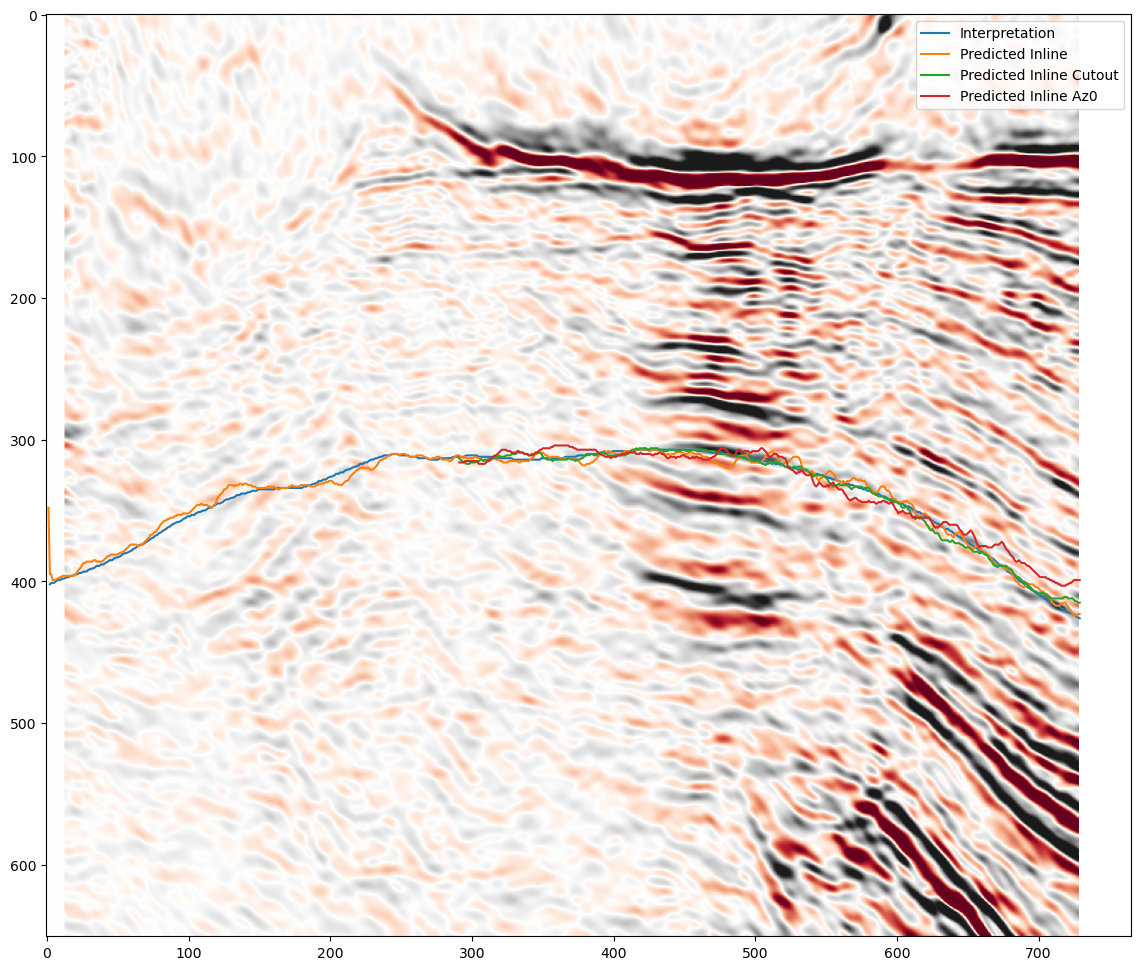

In [80]:
# plot horizons
horz_original = r"E:\\seismic_volumes_python\\horizons_ilxl\\M17_P2_C_DD.txt"
horz_predicted_il = r"C:\Users\mustaah\OneDrive - Oxy\All Projects\Active Projects\regressnet-horizon-tracker\results\M17_P2_C_DD_Preds_Inline_All_Volume.txt"
horz_predicted_il_cutout = r"C:\Users\mustaah\OneDrive - Oxy\All Projects\Active Projects\regressnet-horizon-tracker\results\M17_P2_C_DD_Preds_Inline_Cutout.txt"
horz_pred_az0 = r"C:\Users\mustaah\OneDrive - Oxy\All Projects\Active Projects\regressnet-horizon-tracker\results\M17_P2_C_DD_Preds_Inline_Cutout_az0_limit_z.txt"

# plot horizon at this idx position
xl_slice = 301
depth_slice = 500
fig, ax = plt.subplots(figsize=(14,12))

# plot seismic
# ax = plot_seismic_section(seismic, np.sort(unique_ilines), np.sort(unique_xlines), np.sort(samples), ax, il_slice=il_slice)

# plot interpreter pick
ax.imshow(clip(seismic[:,xl_slice,:].T), cmap='RdGy')
il_ind, t_ind= plot_horizon(horz_original, unique_xlines, unique_ilines, samples, xl_slice)
ax.plot(il_ind, t_ind, label='Interpretation')

# plot inline interpretations
il_ind, t_ind= plot_horizon(horz_predicted_il, unique_xlines, unique_ilines, samples, xl_slice)
ax.plot(il_ind, t_ind, label='Predicted Inline')

# plot crossline interpretations
il_ind, t_ind= plot_horizon(horz_predicted_il_cutout, unique_xlines, unique_ilines, samples, xl_slice)
ax.plot(il_ind, t_ind, label='Predicted Inline Cutout')

# plot crossline interpretations
il_ind, t_ind= plot_horizon(horz_pred_az0, unique_xlines, unique_ilines, samples, xl_slice)
ax.plot(il_ind, t_ind, label='Predicted Inline Az0')

plt.legend()
plt.show()

In [18]:
samples[100]

22200.0

In [26]:
# save horizon volume

def gen_horizon_vol(horizon_vol, horizon_id, path_horizon_file, unique_xlines, unique_ilines, samples):
    
    horizon_file = np.genfromtxt(path_horizon_file)
    
    # extract horizon picks
    il_hrz = horizon_file[1:,0].astype(int)
    xl_hrz = horizon_file[1:,1].astype(int)
    t_hrz = horizon_file[1:,2].astype(int)

    # only consider points lying inside the range of the seismic
    mask_valid = (il_hrz >= unique_ilines.min()) & ((il_hrz <= unique_ilines.max())) & (xl_hrz >= unique_xlines.min()) & (xl_hrz <= unique_xlines.max()) & (t_hrz <= samples.max())
    il_hrz = il_hrz[mask_valid]
    xl_hrz = xl_hrz[mask_valid]
    t_hrz = t_hrz[mask_valid]

    # digitize x,y,z positions
    il_inds = np.digitize(il_hrz, bins=np.sort(unique_ilines), right=True)
    xl_inds = np.digitize(xl_hrz, bins=np.sort(unique_xlines), right=True)
    t_inds = np.digitize(t_hrz, bins=np.sort(samples), right=True)

    # store predictions in numpy array
    horizon_vol[il_inds, xl_inds, t_inds] = horizon_id

    return horizon_vol

horizon_vol = np.zeros((unique_ilines.size, unique_xlines.size, samples.size))

horizon_directory = r"E:\seismic_volumes_python\horizons_ilxl"
horizon_file_paths = [join(horizon_directory, file) for file in os.listdir(horizon_directory) if file.endswith('.txt')]
file_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in horizon_file_paths]

# plot horizon at this idx position
for i, file_path in enumerate(horizon_file_paths):
    horizon_vol = gen_horizon_vol(horizon_vol, i+1, file_path, unique_xlines, unique_ilines, samples)

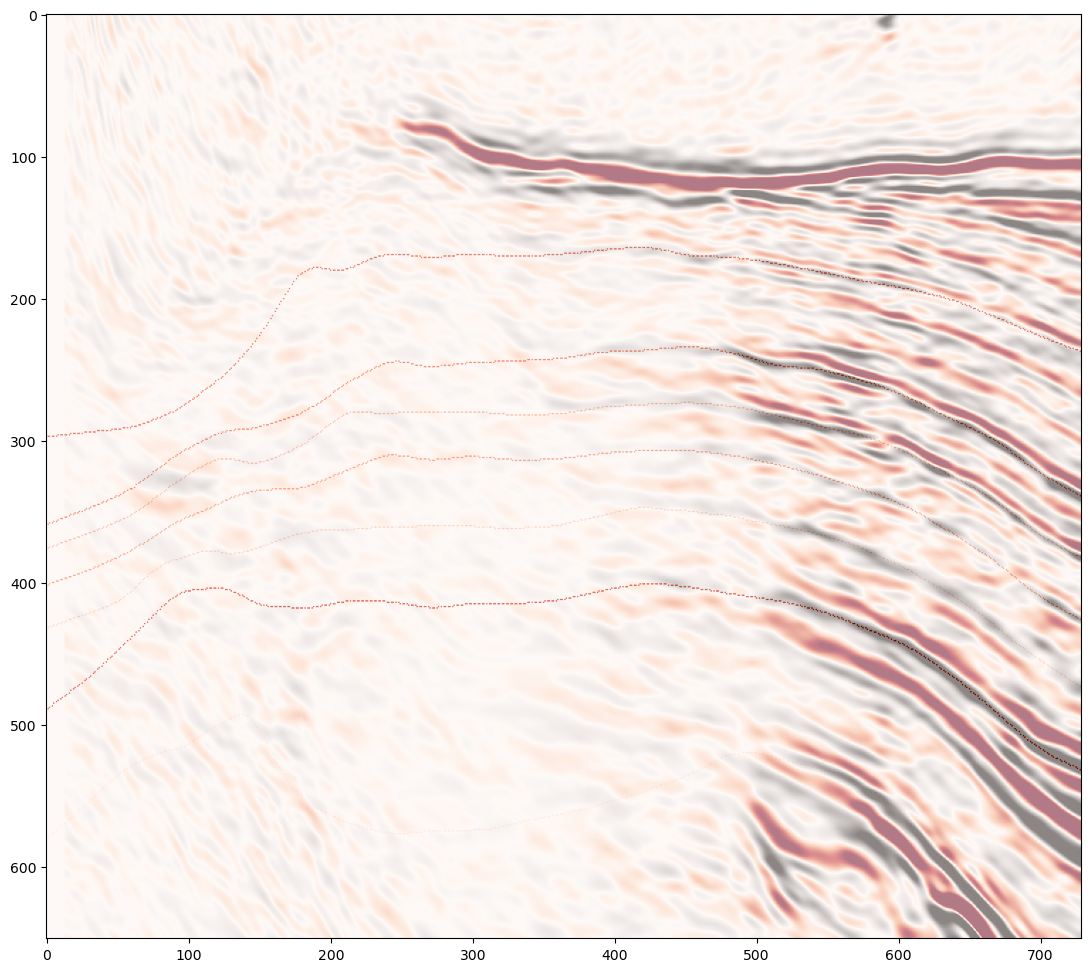

In [28]:
#horizon_vol[horizon_vol!=0] = 1
i = 301
plt.figure(figsize=(15,12))
plt.imshow(clip(seismic[:,i,:].T), cmap='RdGy')
plt.imshow(horizon_vol[:,i,:].T, cmap='Reds', alpha=0.5)
plt.show()

In [27]:
np.save(r"D:\seismic_k2.npy", seismic[400:,200:,:])
np.save(r"D:\horizons_k2.npy", horizon_vol[400:,200:,:])

# Visualizing a 3d seismic volume in mayavi


In [1]:
import numpy as np
import segyio
import matplotlib.pyplot as plt
from mayavi import mlab

In [2]:
seismic_vol = np.load(r"D:\Australia_seismic_faults\seismic_all.npy")[500:1000,500:1000,500:1000]
label_vol = np.load(r"D:\Australia_seismic_faults\labels_all.npy")[500:1000,500:1000,500:1000]

In [32]:
scalars = seismic_vol[:,:,::-1]
mlab.volume_slice(scalars, colormap='seismic', plane_orientation='x_axes', slice_index=10, vmin=-3, vmax=3)
mlab.volume_slice(scalars, colormap='seismic', plane_orientation='y_axes', slice_index=10, vmin=-3, vmax=3)
mlab.volume_slice(scalars, colormap='seismic', plane_orientation='z_axes', slice_index=10, vmin=-3, vmax=3)
#mlab.contour3d(label_vol[:,:,::-1], contours=[1], colormap='Reds')
mlab.show()

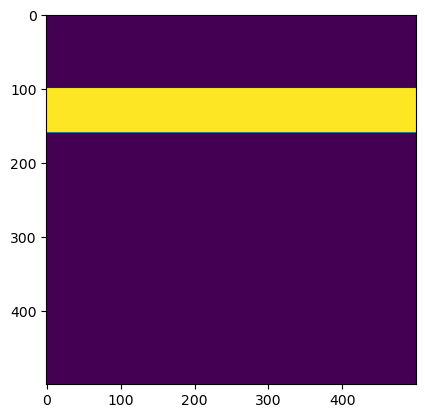

In [31]:
plt.imshow(mask[0].T)

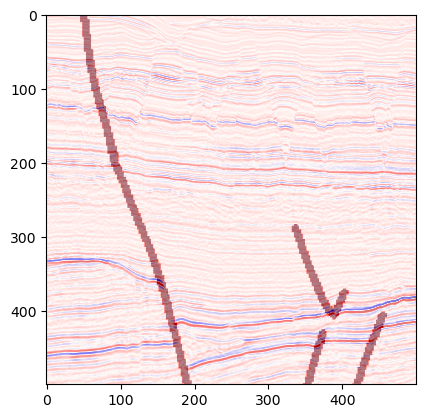

In [10]:
plt.imshow(seismic_vol[0].T, cmap='seismic')
plt.imshow(label_vol[0].T, cmap='Reds', alpha=0.5)
plt.show()

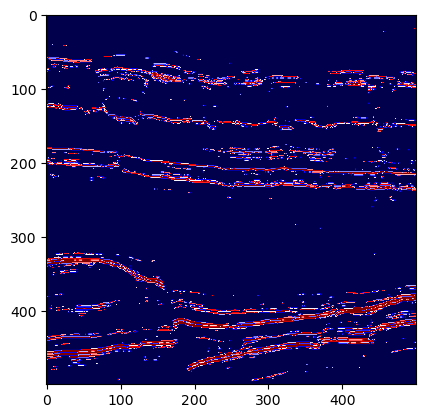

In [30]:
def threshold(array):
    array[array<0.4] = 0
    array[array>0.4] = 1
    return array

amplitude_vol = np.abs(seismic_vol)
pseudo_horizons = threshold(amplitude_vol)

plt.imshow(amplitude_vol[0].T, cmap='seismic')
#plt.imshow(pseudo_horizons[0].T, cmap='Greys', alpha=0.5)
plt.show()

(array([2.362e+05, 8.114e+03, 3.419e+03, 1.173e+03, 4.250e+02, 3.340e+02,
        2.070e+02, 1.060e+02, 1.900e+01, 3.000e+00]),
 array([0.        , 0.11427279, 0.22854557, 0.34281836, 0.45709114,
        0.57136393, 0.68563671, 0.7999095 , 0.91418228, 1.02845507,
        1.14272785]),
 <BarContainer object of 10 artists>)

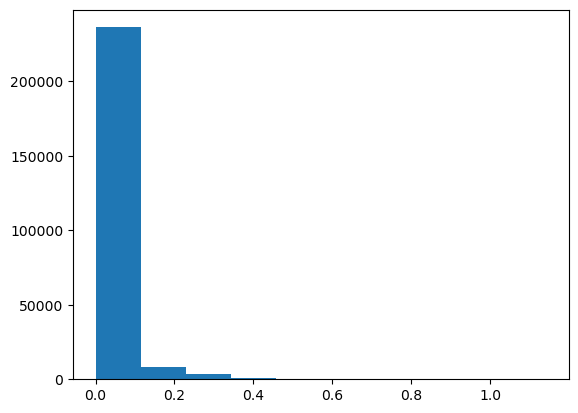

In [17]:
plt.hist(amplitude_vol[0].flatten())

In [4]:
help(mlab.contour3d)

Help on function the_function in module mayavi.tools.helper_functions:

the_function(*args, **kwargs)
    Plots iso-surfaces for a 3D volume of data supplied as arguments.
    
    **Function signatures**::
    
        contour3d(scalars, ...)
        contour3d(x, y, z, scalars, ...)
    
    scalars is a 3D numpy arrays giving the data on a grid.
    
    If 4 arrays, (x, y, z, scalars) are passed, the 3 first arrays give the
    position, and the last the scalar value. The x, y and z arrays are then
    supposed to have been generated by `numpy.mgrid`, in other words, they are
    3D arrays, with positions lying on a 3D orthogonal and regularly spaced
    grid with nearest neighbor in space matching nearest neighbor in the array.
    The function builds a scalar field assuming  the points are regularly
    spaced.
    
    **Keyword arguments:**
    
        :color: the color of the vtk object. Overides the colormap,
                if any, when specified. This is specified as a
    